<a href="https://colab.research.google.com/github/sarahgylee/auto-market-economics/blob/main/Auto_Market_Economics_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Market Economics: The "Rate Squeeze" Analysis

### Executive Summary
This analysis quantifies the correlation between rising interest rates and the market share of North American automotive manufacturers.

### Methodology
1. **Data Ingestion**
Automating the retrieval and cleaning of sales data (StatsCan) and financial indicators (Bank of Canada).
2. **Time Series Alignment**
Resampling daily interest rate logs to match monthly sales reporting cycles.
3. **Statistical Modeling**
Calculating Pearson correlation coefficients to validate the hypothesis that higher rates depress domestic market share.

In [1]:
import pandas as pd
import numpy as np

print("Starting Data Pipeline...\n")

# ==========================================
# STEP 1: LOAD & CLEAN CAR SALES DATA
# ==========================================
# Load the raw CSV file
df_cars = pd.read_csv('car_sales.csv')

# Select only the necessary columns: Date, Origin, and Sales Volume
df_cars_clean = df_cars[['REF_DATE', 'Origin of manufacture', 'VALUE']].copy()

# Rename columns for clarity (Standardizing naming convention)
df_cars_clean.columns = ['Date', 'Origin', 'Sales']

# Convert 'Date' column to datetime objects
df_cars_clean['Date'] = pd.to_datetime(df_cars_clean['Date'])

# Pivot the table to separate 'North America' and 'Overseas' into distinct columns
# This allows us to calculate market share easier
df_car_pivot = df_cars_clean.pivot_table(index='Date', columns='Origin', values='Sales', aggfunc='sum')

# Calculate 'North American Market Share' (%)
# Formula: (North American Sales / Total Sales) * 100
df_car_pivot['Total_Sales'] = df_car_pivot.sum(axis=1)
df_car_pivot['NA_Share'] = (df_car_pivot['North America'] / df_car_pivot['Total_Sales']) * 100

print(f"Step 1 Complete: Car Sales Data Processed ({len(df_car_pivot)} months)")


# ==========================================
# STEP 2: LOAD & CLEAN INTEREST RATES
# ==========================================
# The Bank of Canada CSV often has metadata at the top.
# We scan the file first to find the header row dynamically.
skip_rows = 0
with open('interest_rates.csv', 'r') as f:
    for i, line in enumerate(f):
        if line.lower().strip().startswith('date'):
            skip_rows = i
            break

# Load the CSV skipping the metadata rows
df_rates = pd.read_csv('interest_rates.csv', skiprows=skip_rows)

# Clean column names (remove whitespace and convert to lowercase)
df_rates.columns = [c.strip().lower() for c in df_rates.columns]

# Identify Date and Rate columns dynamically
date_col = 'date'
rate_col = df_rates.columns[-1] # The rate is usually in the last column

# Convert data types
df_rates[date_col] = pd.to_datetime(df_rates[date_col])
# Force numeric conversion (This handles "Bank holiday" text by turning it into NaN)
df_rates[rate_col] = pd.to_numeric(df_rates[rate_col], errors='coerce')

# Drop missing values (Holidays) and set Date as Index
df_rates = df_rates.dropna(subset=[rate_col]).set_index(date_col)

# Resample Daily data to Monthly Averages to match Car Sales data frequency
df_rates_monthly = df_rates.resample('MS').mean()
df_rates_monthly.rename(columns={rate_col: 'Interest_Rate'}, inplace=True)

print(f"Step 2 Complete: Interest Rates Processed ({len(df_rates_monthly)} months)")


# ==========================================
# STEP 3: LOAD & CLEAN CPI (Inflation)
# ==========================================
df_cpi = pd.read_csv('cpi.csv')

# Filter for 'All-items' to get the general inflation index
# (If your file doesn't have the 'Products' column, it might already be filtered. This check is safe.)
if 'Products and product groups' in df_cpi.columns:
    df_cpi = df_cpi[df_cpi['Products and product groups'] == 'All-items']

# Select and rename columns
df_cpi_clean = df_cpi[['REF_DATE', 'VALUE']].copy()
df_cpi_clean.columns = ['Date', 'CPI_Index']

# Convert Date and set as Index
df_cpi_clean['Date'] = pd.to_datetime(df_cpi_clean['Date'])
df_cpi_clean = df_cpi_clean.set_index('Date')

# Calculate Inflation Rate (Year-Over-Year % Change)
df_cpi_clean['Inflation_Rate'] = df_cpi_clean['CPI_Index'].pct_change(periods=12) * 100

print(f"Step 3 Complete: CPI Data Processed ({len(df_cpi_clean)} months)")


# ==========================================
# STEP 4: MERGE & EXPORT
# ==========================================
# Merge all datasets on the 'Date' index
# We use 'inner' join to keep only the timeline where we have ALL metrics
df_final = df_car_pivot.join([df_rates_monthly, df_cpi_clean], how='inner')

print("\n Final Dataset Ready!")
print("-" * 30)
display(df_final.tail())

Starting Data Pipeline...

Step 1 Complete: Car Sales Data Processed (71 months)
Step 2 Complete: Interest Rates Processed (72 months)
Step 3 Complete: CPI Data Processed (72 months)

 Final Dataset Ready!
------------------------------


,North America,"Total, overseas",Total_Sales,NA_Share,Interest_Rate,CPI_Index,Inflation_Rate
2025-07-01,118909,60892,179801,66.133670,2.750000,164.9,1.727329
2025-08-01,110141,56383,166524,66.141217,2.750000,164.8,1.854141
2025-09-01,112128,56603,168731,66.453704,2.647727,164.9,2.358783
2025-10-01,110394,55208,165602,66.662238,2.477273,165.3,2.163164
2025-11-01,99843,50989,150832,66.194839,2.250000,165.4,2.224969


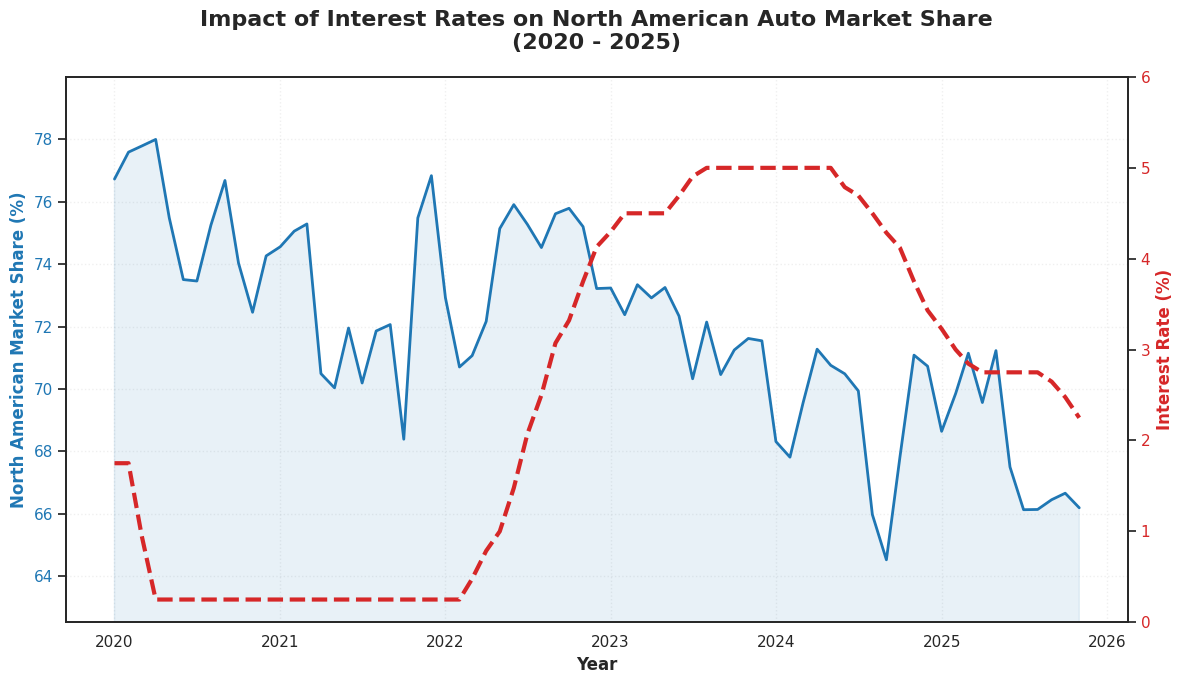


STATISTICAL INSIGHT:
Correlation between Interest Rates and Market Share: -0.40
Interpretation: Weak/Moderate negative correlation.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set the visual style to look professional
sns.set(style="white")

# Initialize the figure size
fig, ax1 = plt.subplots(figsize=(12, 7))

# ---------------------------------------------------------
# Plot 1: North American Market Share (Left Y-Axis)
# ---------------------------------------------------------
color_share = '#1f77b4' # Professional Blue
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('North American Market Share (%)', color=color_share, fontsize=12, fontweight='bold')

# Plot as a filled area to show "Volume/Base"
ax1.plot(df_final.index, df_final['NA_Share'], color=color_share, linewidth=2, label='NA Market Share')
ax1.fill_between(df_final.index, df_final['NA_Share'], alpha=0.1, color=color_share)
ax1.tick_params(axis='y', labelcolor=color_share)

# Dynamic Y-Axis limits (zooms in to make the trend visible)
y_min = df_final['NA_Share'].min() - 2
y_max = df_final['NA_Share'].max() + 2
ax1.set_ylim(y_min, y_max)

# ---------------------------------------------------------
# Plot 2: Interest Rates (Right Y-Axis)
# ---------------------------------------------------------
ax2 = ax1.twinx()  # Create a second Y-axis that shares the same X-axis
color_rate = '#d62728' # Alert Red

ax2.set_ylabel('Interest Rate (%)', color=color_rate, fontsize=12, fontweight='bold')
ax2.plot(df_final.index, df_final['Interest_Rate'], color=color_rate, linewidth=3, linestyle='--', label='Interest Rate')
ax2.tick_params(axis='y', labelcolor=color_rate)

# Set Interest Rate limit (0% to slightly above max)
ax2.set_ylim(0, df_final['Interest_Rate'].max() + 1)

# ---------------------------------------------------------
# Formatting & Titles
# ---------------------------------------------------------
# Format the X-axis to show years clearly (e.g., 2021, 2022)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

# Add a Title that tells the story
plt.title('Impact of Interest Rates on North American Auto Market Share\n(2020 - 2025)', fontsize=16, fontweight='bold', pad=20)

# Add gridlines for readability
ax1.grid(True, alpha=0.3, linestyle=':')

# Save the chart
plt.tight_layout()
plt.savefig('market_share_vs_rates.png', dpi=300)
plt.show()

# ---------------------------------------------------------
# Statistical Proof: Correlation Coefficient
# ---------------------------------------------------------
correlation = df_final['NA_Share'].corr(df_final['Interest_Rate'])
print("\n" + "="*50)
print(f"STATISTICAL INSIGHT:")
print(f"Correlation between Interest Rates and Market Share: {correlation:.2f}")
print("="*50)
if correlation < -0.5:
    print("Interpretation: Strong NEGATIVE correlation.\nAs rates go UP, Market Share goes DOWN.")
elif correlation < 0:
    print("Interpretation: Weak/Moderate negative correlation.")
else:
    print("Interpretation: No negative correlation found (Unexpected).")

In [3]:
df_final.to_csv('df_final.csv')
print("df_final.csv has been saved to your session storage.")

df_final.csv has been saved to your session storage.
